In [36]:
# To Do
    
    # Re coment 
    # Correct speling mistake 
    # Ad observation (optional)

# 1Qubit Event Classification using Data-reuploadind 

Description :

    - dev: simulator.
    - number of qubits: 1;
    - number of layers: 4;
    - number of varables: 3;
    - number of parameters: 12;
    - number of epochs: 20;
    - final parameters:     
    [[ 1.1203314   0.12239342  1.0189791 ]
     [ 0.94256891  0.17469264  0.3877136 ]
     [ 0.26917547  1.28770832 -0.12372992]
     [-6.53098944  0.11591529  0.96990986]];
    - final AUC:0.828.
    
    

Observation:
    
    - Using just 1 qubit in 20 epoch we get an AUC= 0.828 but unfortunatley the accuracy is just 0.622 on test data. But these is steel impressive taking in consideration that AUC for VQE on simulator is in as is 0.815 +/- 0.015 presented in [3] and for QCL is 0.833+/-0.063 for depth 3 and 63 parameters.
    - Since we use just one qubit we expected that our algorith will perform better on real hardwar since we don't use cross resonance gate.

The algorithm fro Data re-uploading is first presented in [2].
In these note book we slightly modify Notebook from [1] to make it work on SUSY data set [4]. 

In [2]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import pandas as pd

import sklearn

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import  PCA
from sklearn.metrics import roc_auc_score


In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer,  AdagradOptimizer

In [4]:
# Set a random seed
np.random.seed(42)

In [ ]:
# Get training and test data

# we wiil use jut 500 data for training and 5000 data for test because of time constrains
num_training = 500
num_test = 5000 

label=['signal','lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

# select variable that we will use in our model
var=['lepton 1 pT','lepton 2 pT','missing energy magnitude']

df=pd.read_csv('~/SageMaker/SUSY_cut.csv',nrows=(num_training+num_test))



Xdata=df[var].to_numpy()
Ydata=df['signal'].to_numpy()



In [6]:
# Data normalisation:

min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(Xdata)

# train/test data
X_train=X_scaled[:num_training]
y_train=Ydata[:num_training]

X_test=X_scaled[num_training:]
y_test=Ydata[num_training:]

In [19]:
def plot_data_3(x,y,fig=None,ax=None,feature_name=['feature_1','feature_2','feature_3']):
    
    color=['r' if y[i]==1  else 'b' for i in range(len(y))]

    feature_1=[]
    for i in range(len(x)):
        feature_1.append(x[i][0])
    
    feature_2=[]
    for i in range(len(x)):
        feature_2.append(x[i][1])
    
    feature_3=[]
    for i in range(len(x)):
        feature_3.append(x[i][2])

    ax=Axes3D(fig)
    ax.scatter(feature_1,feature_2,feature_3,color=color)
    ax.set_xlabel(feature_name[0])
    ax.set_ylabel(feature_name[1])
    ax.set_zlabel([feature_name[2]])

In [34]:
label_0 = [[1], [0]]  #|0>
label_1 = [[0], [1]]  #|1>
state_labels = [label_0, label_1]


# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T

<IPython.core.display.Javascript object>


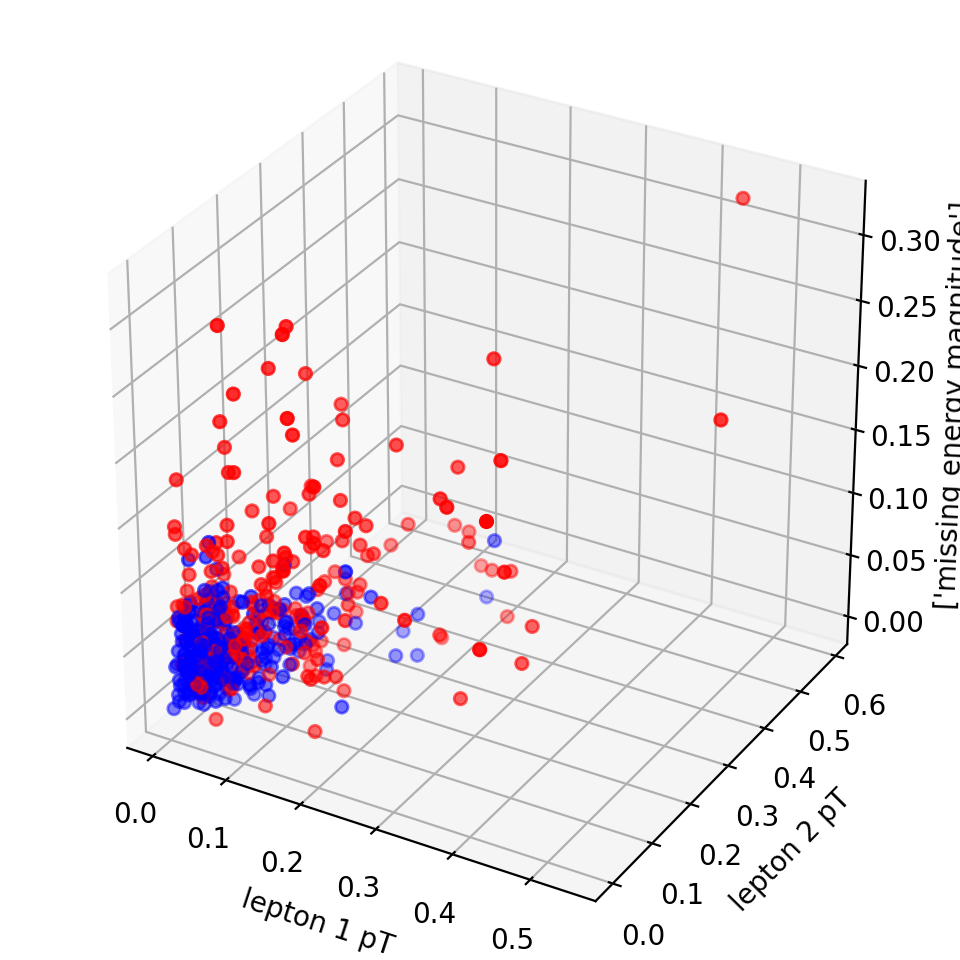

In [35]:
fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot_data_3(X_train,y_train,fig=fig,ax=ax,feature_name=var)

In [10]:
# device 
dev = qml.device("default.qubit", wires=1)

@qml.template
def simpleLayer_3features(p,x,wire):
    qml.Rot(*x, wires=wire)
    qml.Rot(*p, wires=wire)
    
    
@qml.qnode(dev)
def qcircuit(params, x, y):
    """
    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    qml.Hadamard(0)
    for p in params:
        simpleLayer_3features(p,x,wire=0)
        

    return qml.expval(qml.Hermitian(y, wires=[0])) 


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    ##print("dm_labels:",dm_labels)
    for i in range(len(x)):
        i=int(i)
        ##print("dm_labels[yi]:",dm_labels[int(y[i])])
        f = qcircuit(params, x[i], dm_labels[int(y[i])])
        ##print("f",f)
        loss = loss + (1 - f) ** 2
    return loss / len(x)

In [11]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 3-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]


In [12]:
# Train 
num_layers = 4
learning_rate = 0.6
epochs = 20
batch_size = 40

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)


# initialize random weights
params = np.random.uniform(size=(num_layers, 3))


# untrain prediction
predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params = opt.step(lambda v: cost(v, Xbatch, ybatch, state_labels), params)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.288124 | Train accuracy: 0.518000 | Test accuracy: 0.527200
Epoch:  1 | Loss: 0.204362 | Train accuracy: 0.700000 | Test accuracy: 0.712400
Epoch:  2 | Loss: 0.200295 | Train accuracy: 0.686000 | Test accuracy: 0.695800
Epoch:  3 | Loss: 0.245068 | Train accuracy: 0.594000 | Test accuracy: 0.604600
Epoch:  4 | Loss: 0.238395 | Train accuracy: 0.600000 | Test accuracy: 0.610000
Epoch:  5 | Loss: 0.240589 | Train accuracy: 0.598000 | Test accuracy: 0.609400
Epoch:  6 | Loss: 0.221450 | Train accuracy: 0.632000 | Test accuracy: 0.631200
Epoch:  7 | Loss: 0.210982 | Train accuracy: 0.654000 | Test accuracy: 0.649000
Epoch:  8 | Loss: 0.212322 | Train accuracy: 0.650000 | Test accuracy: 0.648200
Epoch:  9 | Loss: 0.213066 | Train accuracy: 0.650000 | Test accuracy: 0.647200
Epoch: 10 | Loss: 0.215068 | Train accuracy: 0.644000 | Test accuracy: 0.644400
Epoch: 11 | Loss: 0.221425 | Train accuracy: 0.638000 | Test accuracy: 0.634000
Epoch: 12 | Loss: 0.225710 | Train accur

Prediction with random parameters:


<IPython.core.display.Javascript object>


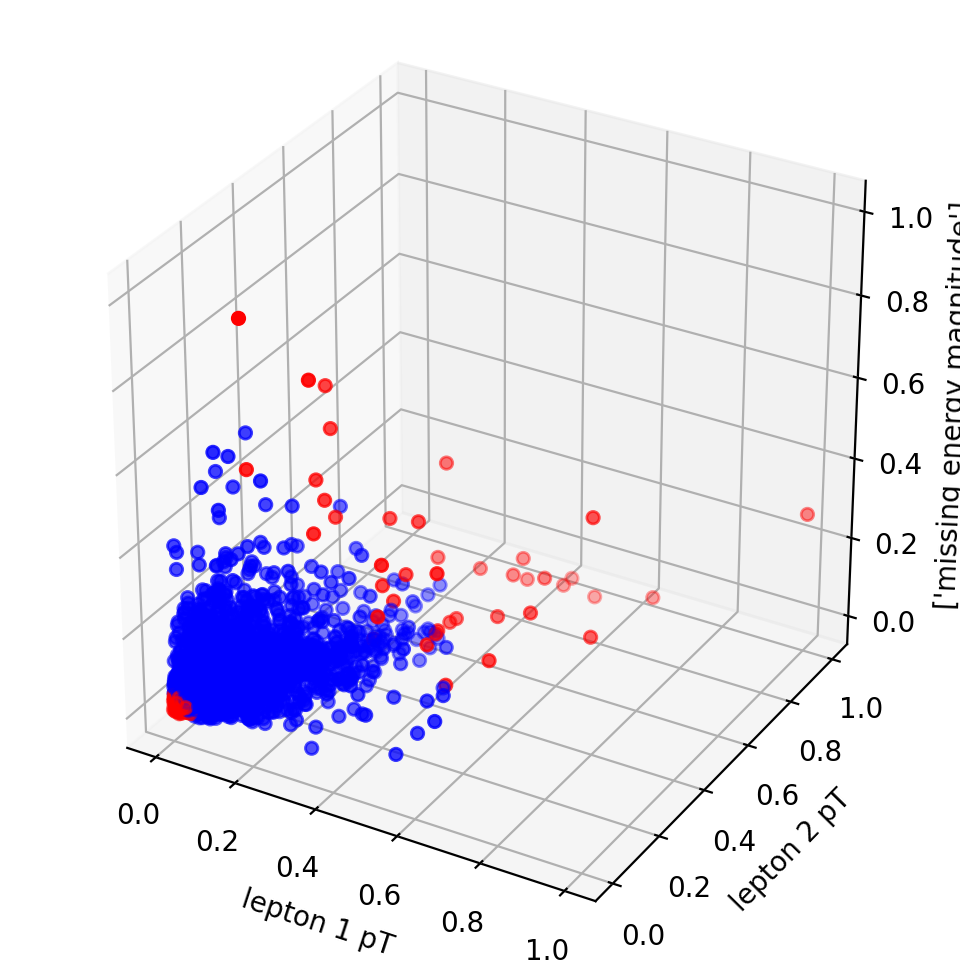

Prediction with trained  parameters:


<IPython.core.display.Javascript object>


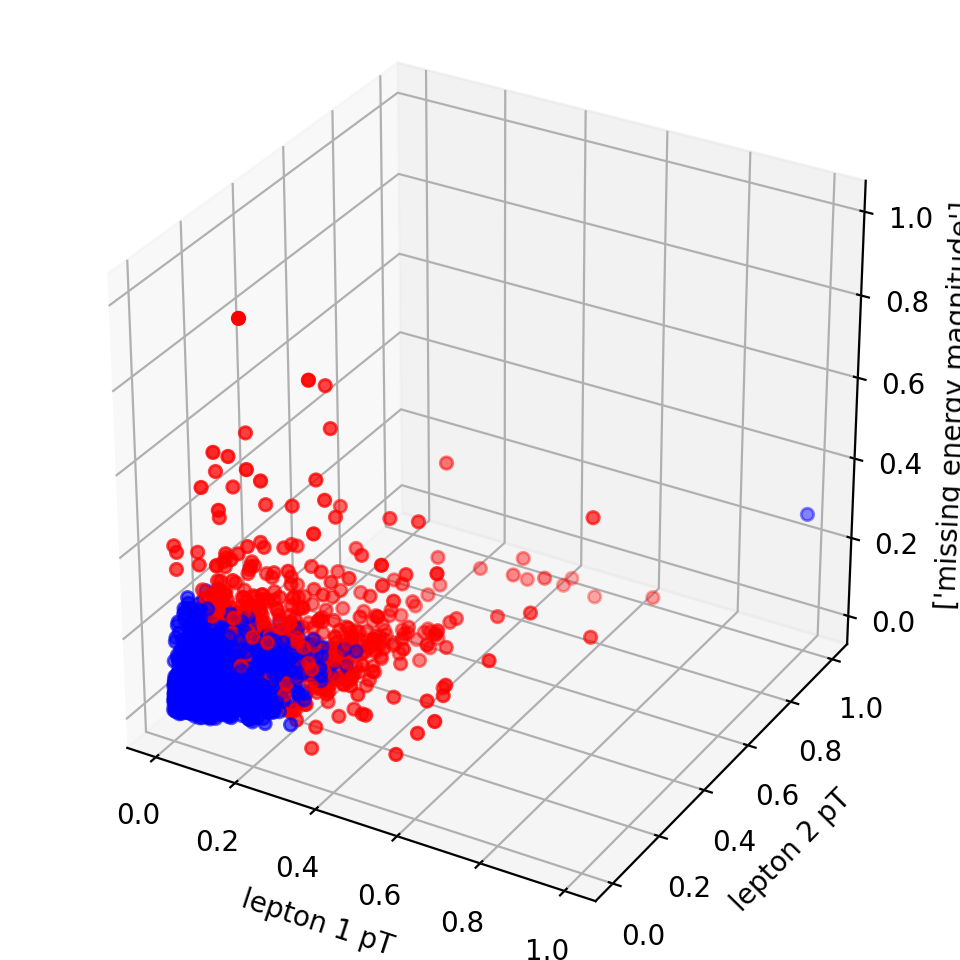

Original data set:


<IPython.core.display.Javascript object>


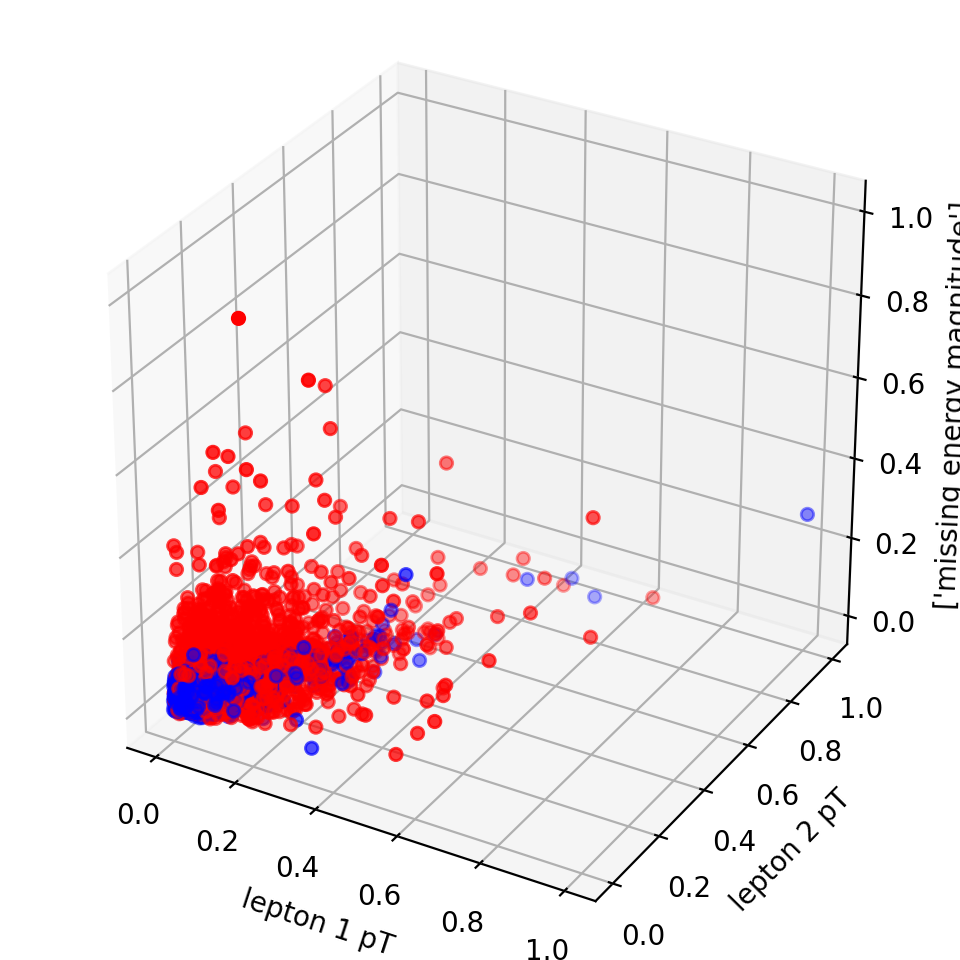

In [33]:
print("Prediction with random parameters:")
fig = plt.figure(figsize=plt.figaspect(1))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
plot_data_3(X_test, initial_predictions, fig, ax1,feature_name=var)

plt.show()

print("Prediction with trained  parameters:")
fig = plt.figure(figsize=plt.figaspect(1))
ax2 = fig.add_subplot(1, 2, 1, projection='3d')

plot_data_3(X_test, predicted_test, fig, ax2,feature_name=var)

plt.show()

print("Original data set:")
fig = plt.figure(figsize=plt.figaspect(1))
ax3 = fig.add_subplot(1, 2, 1, projection='3d')

plot_data_3(X_test, y_test, fig, ax3,feature_name=var)


plt.show()

In [25]:
print("Final parameters:")
print(params)
AUC=roc_auc_score(y_test,fidel_test[:,1])
print("AUC:",AUC)

Final parameters:
[[ 1.1203314   0.12239342  1.0189791 ]
 [ 0.94256891  0.17469264  0.3877136 ]
 [ 0.26917547  1.28770832 -0.12372992]
 [-6.53098944  0.11591529  0.96990986]]
AUC: 0.8282369172677543


## References

[1] [Pennylane Data-reuploading classifier:](https://pennylane.ai/qml/demos/tutorial_data_reuploading_classifier.html)
        
[2] [Pérez-Salinas, Adrián, et al. “Data re-uploading for a universal quantum classifier:](https://arxiv.org/abs/1907.02085)
        
[3] [Koji Terashi · Michiru Kaneda · Tomoe Kishimoto · Masahiko Saito · Ryu Sawada · Junichi Tanaka Event Classification with Quantum Machine Learning in High-Energy Physics:](https://arxiv.org/abs/2002.09935)
    
[4] [Baldi, P., Sadowski, P., Whiteson, D.: Searching for Ex- otic Particles in High-Energy Physics with Deep Learn- ing. Nature Commun. 5, 4308 (2014). DOI 10.1038/ ncomms5308:](https://arxiv.org/abs/1402.4735)
